In [46]:
#Import Libraries
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import mplcursors
import plotly.express as px
import altair as alt

from sklearn.metrics import pairwise_distances
from sklearn.manifold import TSNE

import ipywidgets as widgets
from IPython.display import display, HTML

import dash
from dash import dcc, html
from dash.dependencies import Input, Output

import warnings
warnings.filterwarnings('ignore')

### Load Data

In [47]:
national_df = pd.read_csv("Data/national_data.csv")
states_df = pd.read_csv("Data/states_data.csv")

In [48]:
#Look at state Names per Year
states_df.head(10)

,state,sex,year,name,count,region
0,AK,F,1910,Mary,14,West
1,AK,F,1910,Annie,12,West
2,AK,F,1910,Anna,10,West
3,AK,F,1910,Margaret,8,West
4,AK,F,1910,Helen,7,West
5,AK,F,1910,Elsie,6,West
6,AK,F,1910,Lucy,6,West
7,AK,F,1910,Dorothy,5,West
8,AK,F,1911,Mary,12,West
9,AK,F,1911,Margaret,7,West


In [49]:
# Create a dropdown widget for selecting the year
year_selector = widgets.Dropdown(
    options=sorted(states_df['year'].unique()),
    description='Select Year:',
    disabled=False
)

# Define a function to update the plots based on the selected year
def update_plots(year):
    # Filter the DataFrame based on the selected year
    filtered_df = states_df[states_df['year'] == year]
    
    # Filter out only the data for male and female separately
    male_df = filtered_df[filtered_df['sex'] == 'M']
    female_df = filtered_df[filtered_df['sex'] == 'F']
    
    # Group by State and Name and sum the counts
    top_male_names = male_df.groupby(['state', 'name'])['count'].sum().reset_index()
    top_female_names = female_df.groupby(['state', 'name'])['count'].sum().reset_index()
    
    # Get top male and female names for each state
    top_male_names = top_male_names.loc[top_male_names.groupby('state')['count'].idxmax()]
    top_female_names = top_female_names.loc[top_female_names.groupby('state')['count'].idxmax()]
    
    # Plot the top male names
    fig_male = px.bar(top_male_names, x='state', y='count', color='name', title='Top Male Names by State')
    
    # Plot the top female names
    fig_female = px.bar(top_female_names, x='state', y='count', color='name', title='Top Female Names by State')
    
    # Show the plots
    display(fig_male)
    display(fig_female)

# Call the update_plots function when the value of the dropdown changes
widgets.interactive(update_plots, year=year_selector)

interactive(children=(Dropdown(description='Select Year:', options=(1910, 1911, 1912, 1913, 1914, 1915, 1916, …

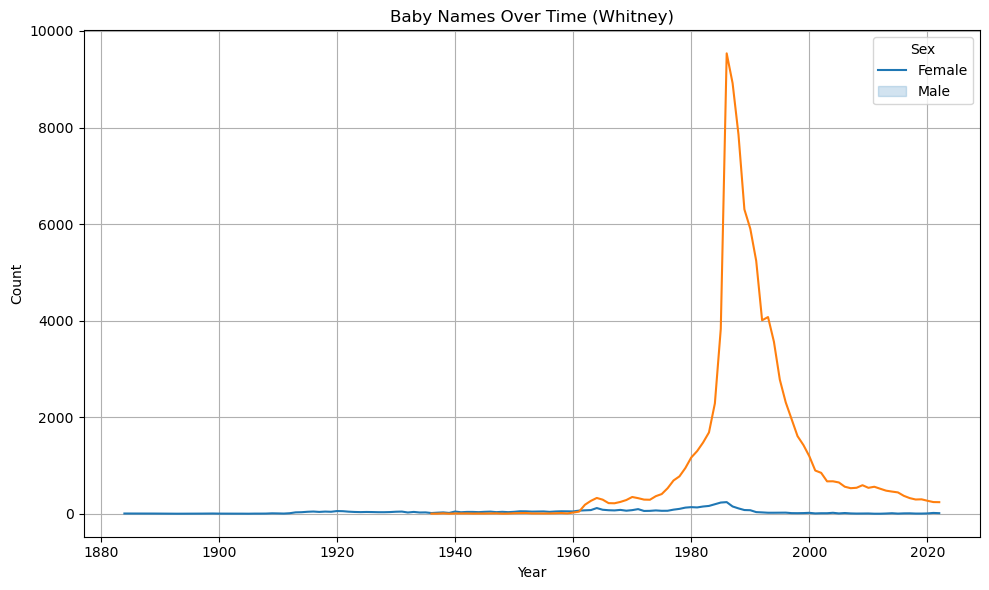

In [50]:
df_whitney = national_df.query('(name == "Whitney") and (sex in ["F", "M"])')

# Create line plots using seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_whitney, x='year', y='count', hue='sex')

plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Baby Names Over Time (Whitney)')

plt.grid(True)

# Get the current Axes object and modify the legend
ax = plt.gca()
legend = ax.legend(title='Sex', labels=['Female', 'Male'])
legend.set_title('Sex')

plt.tight_layout()

plt.show()

### Create Dropdown

In [51]:
# Create a function to get the top 10 names for a given year and sex
def get_top_names(year):
    top_male_names = national_df[(national_df['sex'] == 'M') & (national_df['year'] == year)].nlargest(10, 'count')['name'].tolist()
    top_female_names = national_df[(national_df['sex'] == 'F') & (national_df['year'] == year)].nlargest(10, 'count')['name'].tolist()
    return top_male_names, top_female_names

# Create widget for selecting year
year_dropdown = widgets.Dropdown(options=national_df['year'].unique(), description='year:')

# Create function that updates the output widget when the year is changed
def update_output(year):
    top_male_names, top_female_names = get_top_names(year)
    output_widget.clear_output()
    with output_widget:
        display(HTML(f'<h3>Top 10 Male Names for {year}</h3><ul><li>{"</li><li>".join(top_male_names)}</li></ul>'))
        display(HTML(f'<h3>Top 10 Female Names for {year}</h3><ul><li>{"</li><li>".join(top_female_names)}</li></ul>'))

# Create an output widget for displaying the top names
output_widget = widgets.Output()

# Display the widgets
display(year_dropdown)
display(output_widget)

# Call the update_output function when the year is changed
widgets.interactive(update_output, year=year_dropdown)

Dropdown(description='year:', options=(1880, 1881, 1882, 1883, 1884, 1885, 1886, 1887, 1888, 1889, 1890, 1891,…

Output()

interactive(children=(Dropdown(description='year:', options=(1880, 1881, 1882, 1883, 1884, 1885, 1886, 1887, 1…

### Names with biggest increases

In [52]:
# Calculate the total count of each name for each year and sex
name_counts = national_df.groupby(['name', 'sex', 'year']).sum().reset_index()

# Calculate the percentage increase of each name from one year to the next
name_counts['percentage_increase'] = name_counts.groupby(['name', 'sex'])['count'].pct_change()

# Find the names with the highest percentage increase over time for both males and females
top_male_names = name_counts[name_counts['sex'] == 'M'].nlargest(10, 'percentage_increase')
top_female_names = name_counts[name_counts['sex'] == 'F'].nlargest(10, 'percentage_increase')

# Display the top male and female names with the biggest increases over time
print("Top 10 Male Names with the Biggest Increases Over Time:")
print(top_male_names[['name', 'percentage_increase']])

print("\nTop 10 Female Names with the Biggest Increases Over Time:")
print(top_female_names[['name', 'percentage_increase']])

Top 10 Male Names with the Biggest Increases Over Time:
             name  percentage_increase
1531941   Omarion            82.600000
1182705     Lavar            54.800000
864347     Jaheim            54.400000
59947    Alexande            49.166667
1898294     Tevin            45.692308
874387      Jalen            39.800000
506824     Demond            39.300000
974004     Jonael            37.666667
643317     Ermias            33.800000
938268   Jermaine            33.200000

Top 10 Female Names with the Biggest Increases Over Time:
            name  percentage_increase
1461145    Nakia           161.142857
902223   Jaslene            99.200000
1849306  Tabatha            99.000000
335949    Catina            96.928571
508748    Deneen            71.909091
42630    Akeelah            66.166667
1338     Aaliyah            64.954545
1118384   Kizzie            56.200000
1862115  Tamatha            43.400000
412605   Coraima            43.200000


### Most Popular Name by State Over Time

In [53]:
def process_and_plot_data(df, sex):
    # Filter dataframe by sex
    filtered_df = df[df['sex'] == sex]
    
    # Group by Year, State, and Name, and Sum Count
    top_names_per_year_state = filtered_df.groupby(['year', 'state', 'name'])['count'].sum().reset_index()
    # Sort values
    top_names_per_year_state = top_names_per_year_state.sort_values(by=['year', 'state', 'count'], ascending=False)
    # Get top name for each year
    top_names_per_year_state = top_names_per_year_state.groupby(['year', 'state']).first().reset_index()

    # Plotly choropleth map
    fig = px.choropleth(locations=top_names_per_year_state['state'],
                        locationmode="USA-states",
                        color=top_names_per_year_state['name'],
                        scope="usa",
                        animation_frame=top_names_per_year_state['year'],
                        title=f"Top {sex} Baby Name by State and Year",
                        labels={'color': f'Top {sex} name'},
                        hover_name=top_names_per_year_state['name'],
                        color_continuous_scale=px.colors.sequential.Plasma)


    fig.update_layout(geo=dict(bgcolor='rgba(0,0,0,0)',
                               lakecolor='rgba(0,0,0,0)'))

    fig.show()

In [54]:
# Plot most popular male name in US by state over time
process_and_plot_data(states_df, 'M')  # for male

In [55]:
# Plot most popular female name in US by state over time
process_and_plot_data(states_df, 'F')  # for female

### Name Popularity Dashboard

In [56]:
# Create Dash app
app = dash.Dash(__name__)

# Define layout of the dashboard
app.layout = html.Div([
    html.H1("Name Popularity Dashboard"),
    html.Div([
        dcc.Input(id='input-name', type='text', placeholder='Enter your name'),
        dcc.Input(id='input-year', type='number', placeholder='Enter your birth year'),
        html.Button('Submit', id='submit-button', n_clicks=0)
    ]),
    html.Div(id='output-rank'),
    html.Div(id='output-similar-name')
])

# Callback to calculate rank and find similar name
@app.callback(
    [Output('output-rank', 'children'),
     Output('output-similar-name', 'children')],
    [Input('submit-button', 'n_clicks')],
    [dash.dependencies.State('input-name', 'value'),
     dash.dependencies.State('input-year', 'value')]
)
def update_output(n_clicks, name, year):
    if n_clicks > 0:
        # Filter dataframe for the given year
        year_df = national_df[national_df['year'] == year]
        
        # Calculate rank of the given name
        rank = year_df[year_df['name'] == name]['count'].rank(ascending=False).iloc[0]
        
        # Find a name with the same rank in the dataframe
        similar_name = year_df[year_df['count'].rank(ascending=False) == rank]['name'].iloc[0]
        
        return f"Rank of {name} in {year}: {int(rank)}", f"A similar name in {year} with the same rank: {similar_name}"
    else:
        return '', ''

# Run the app
if __name__ == '__main__':
    app.run_server(debug=True, port=8052)

### Get Top Names for Specific Year

In [57]:
def plot_top_names(year, sex):
    # Filter for the given year and sex
    year_data = states_df[(states_df['year'] == year) & (states_df['sex'] == sex)]
    
    # Group by name and sum the counts
    top_names = year_data.groupby('name')['count'].sum().nlargest(10)
    
    # Plotting top names
    plt.figure(figsize=(10, 6))
    top_names.plot(kind='bar', color='skyblue')
    plt.title(f'Top 10 {sex.capitalize()} Names in {year}')
    plt.xlabel('Name')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

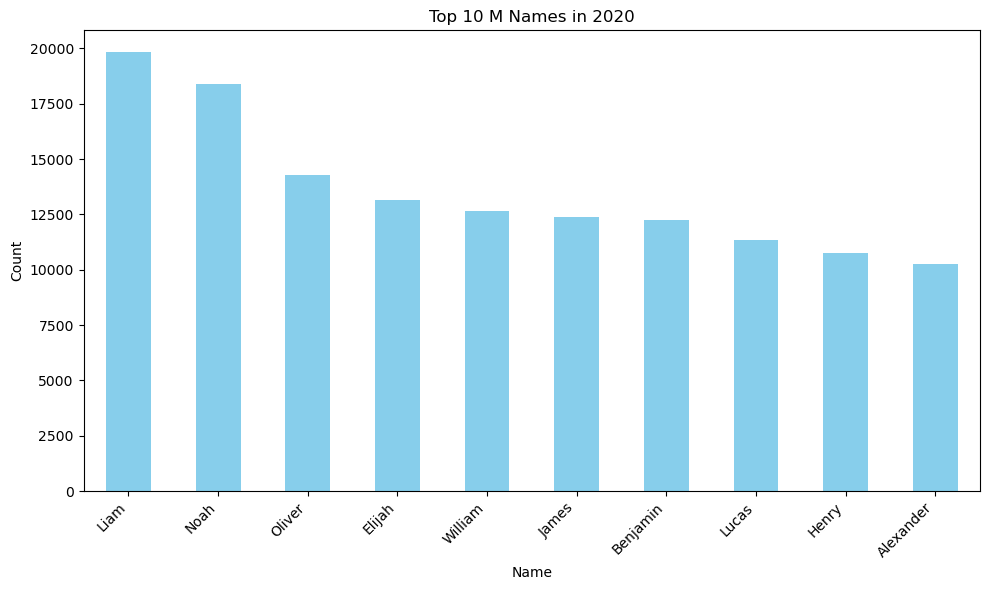

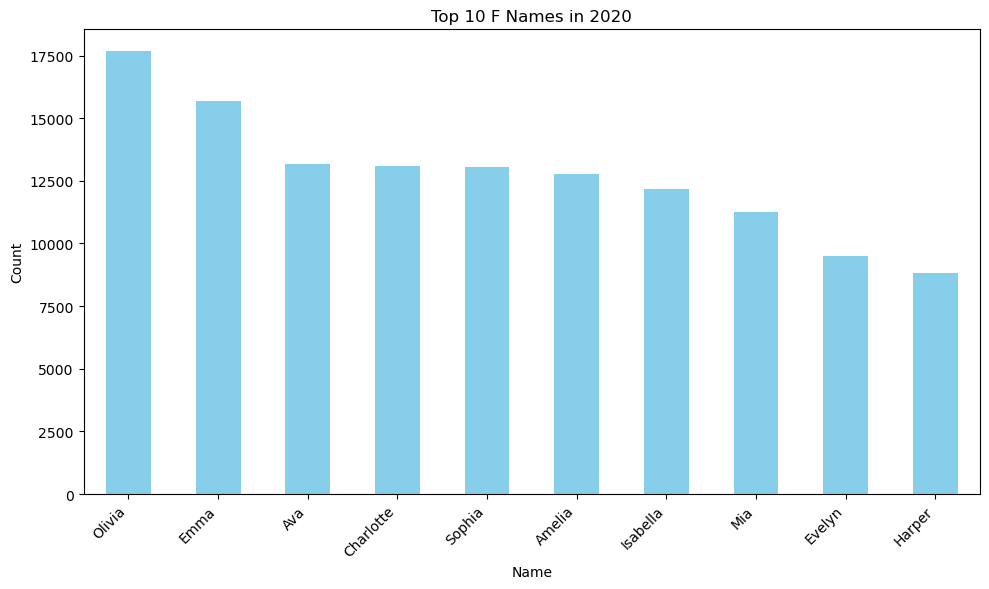

In [58]:
plot_top_names(2020, 'M')  # Plot top male names in 2020
plot_top_names(2020, 'F')  # Plot top female names in 2020

### Regional Name Preferences

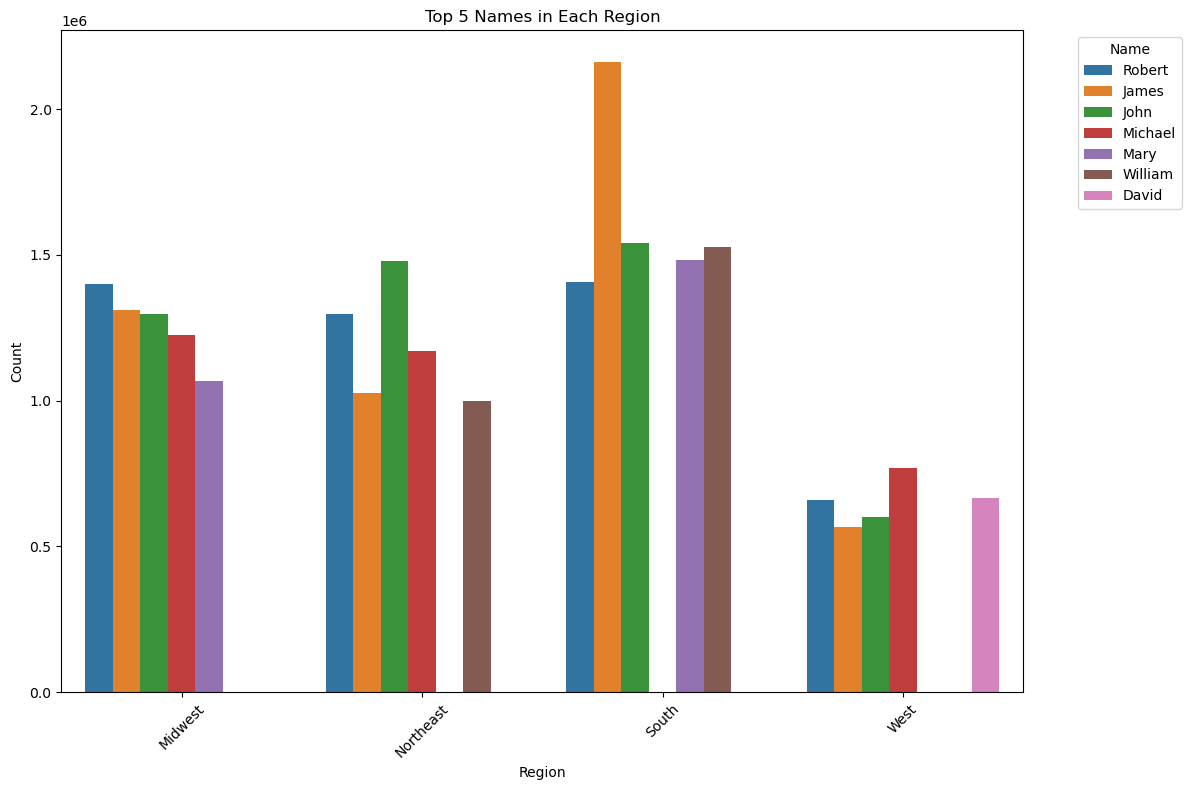

In [59]:
# Group by region and name to get the total counts of each name in each region
region_name_counts = states_df.groupby(['region', 'name'])['count'].sum().reset_index()

# Filter to get top names in each region (you can adjust the number of top names as needed)
top_names_per_region = region_name_counts.groupby('region').apply(lambda x: x.nlargest(5, 'count'))

# Create a grouped bar chart
plt.figure(figsize=(12, 8))
sns.barplot(data=top_names_per_region, x='region', y='count', hue='name')
plt.title('Top 5 Names in Each Region')
plt.xlabel('Region')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Name', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()